Exercise Sheet 9 **Reinforcement Learning II**

__Adu Matory__ and __Lukas Braun__, December 13

In [0]:
import numpy as np
import matplotlib.pyplot as plt

**1 Good vs. bad Doener**

In [0]:
def epsilon_greedy(Q, epsilon, n_actions, s):
    """
    @param Q Q values state x action -> value
    @param epsilon for exploration
    @param s number of states
    """
    if np.random.rand() > epsilon:
        action = np.argmax(Q[s])
    else:
        action = np.random.randint(0, n_actions)
    return action

In [0]:
# 1.1/1.2

np.random.seed(1234)

# setting rewards in landscape
rewards = np.repeat(-10,52) 
rewards[1] = 1000
rewards[-2] = 100

# hyperparameters
eta = .1
eps = .1
gamma = 1
states = 52
trials = 50000

Q = np.zeros((states, trials)) # allocating for all Qs
Q[:,0] = np.random.random(states)/30 # initial small, random Q values

ttc = np.zeros(trials) # time to converge

def run_SARSA_agent(Q,rewards,trials,eta,gamma,eps,ttc):

  for i in range(trials-1):

    s = np.random.choice(np.arange(len(Q)-4))+2 # intial state, must be in range [2 - 49]
    old_s = s
    r = rewards[s] # intial reward
    t = i+1 # initial timestep

    trialQs = Q[:,i] # Qs of previous timestep
    # trialQs[[0,-1]] = 0
    trialQs[[0,2,-1,-3]] = 0 # introduce two additional states at the borders of the
                         # environment whose Q-values are always 0

    while rewards[old_s] < 0: # while non-zero Q value, update Qs

      # possible transition states
      pts = [s-1, s+1] 

      # choose action with epsilon greedy policy 
      a = epsilon_greedy(trialQs, eps, 2, pts)
      if a == 0:
        a = int(-1)

      # update reward
      r = rewards[s]

      # update Qs
      dQ = eta*(r + gamma * trialQs[s+a] - trialQs[s])
      trialQs[s] += dQ
      trialQs[[0,2,-1,-3]] = 0 # two additional states at borders whose Q-values are always 0

      # update time to converge
      ttc[i] += 1 

      # update state if no reward
      old_s = s
      s += a

    if (t % 9999) == 0:
      print(f'continuing with trial {t}...')
    
    # update trial's final Q-values 
    Q[:,t] = trialQs 
    
  return Q, ttc
 

In [4]:
Q2, ttc2 = run_SARSA_agent(Q,rewards,trials,eta,gamma,eps,ttc)

continuing with trial 10000...
continuing with trial 20000...
continuing with trial 30000...
continuing with trial 40000...


In [0]:
def plot_Q(Q2, ttc2, gamma):
  preferred_action = np.zeros(states-2)
  for i in range(50):
    if Q2[i,-1] < Q2[i+2,-1]: # final trial
      preferred_action[i] = -1
    elif Q2[i,-1] > Q2[i+2,-1]:
      preferred_action[i] = 1
    else:
      preferred_action[i] = 0

  plots = 4
  fig,axs = plt.subplots(1,plots,figsize=(plots*5,4))
  fig.subplots_adjust(wspace=.3, top=.82)
  axs.ravel()

  t2d = 500 # trials to display
  axs[0].plot(ttc2[:t2d])
  axs[0].set_xlabel('trials')
  axs[0].set_ylabel('time to reward (a.u.)')
  axs[0].set_title(f'Sarsa agent learning over {t2d} trials')

  axs[1].plot(Q2[:,:500].T)
  axs[1].set_xlabel('trial')
  axs[1].set_ylabel('Q-values')
  axs[1].set_title('Convergence to Q-values')

  cm = plt.cm.get_cmap('nipy_spectral')
  im = axs[2].scatter(np.arange(50), preferred_action, c=preferred_action ,cmap=cm)
  fig.colorbar(im, ax=axs[2])
  axs[2].set_xlabel('state')
  axs[2].set_ylabel('preferred action')
  axs[2].set_title('agent preference to move up/down')

  upp = np.where(preferred_action==1)[0] # states of Q-values for walking up
  downp = np.where(preferred_action==-1)[0] # and down

  axs[3].plot(upp, Q2[1:-1,-1][upp],label='walking up')
  axs[3].plot(downp, Q2[1:-1,-1][downp],label='walking down')
  axs[3].set_xlabel('state')
  axs[3].set_ylabel('Q-value')
  axs[3].set_title('Q-values for walking up/down')
  axs[3].legend()

  fig.suptitle(r'$\gamma$  =  ' + f'{gamma}')

  plt.show()

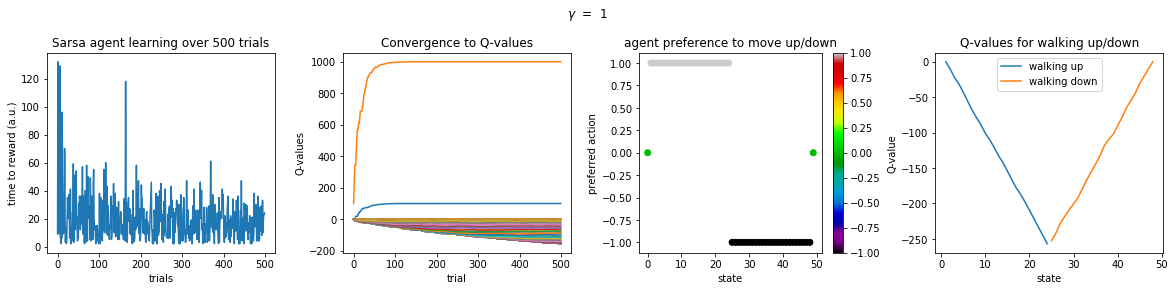

In [6]:
plot_Q(Q2,ttc2,gamma)

The agent's behavior improves faster than the Q-values converge because of dual positive reward and the negative reward. After learning, the agent exploits the environment and just goes to the closer doner. Hunger is a hell of a motivator.

continuing with trial 10000...
continuing with trial 20000...
continuing with trial 30000...
continuing with trial 40000...


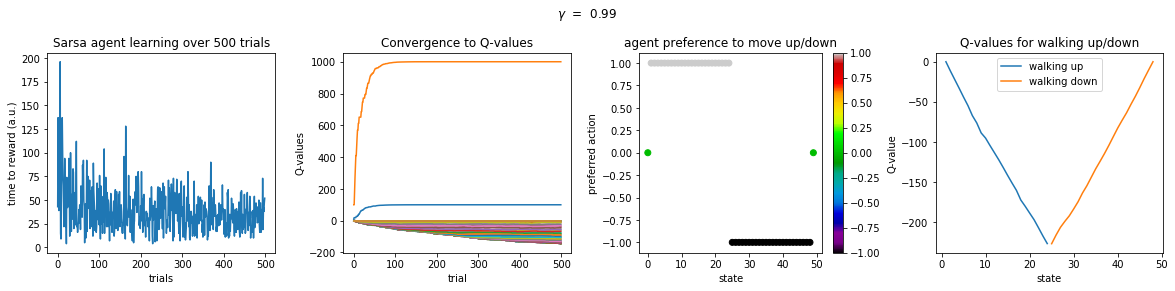

continuing with trial 10000...
continuing with trial 20000...
continuing with trial 30000...
continuing with trial 40000...


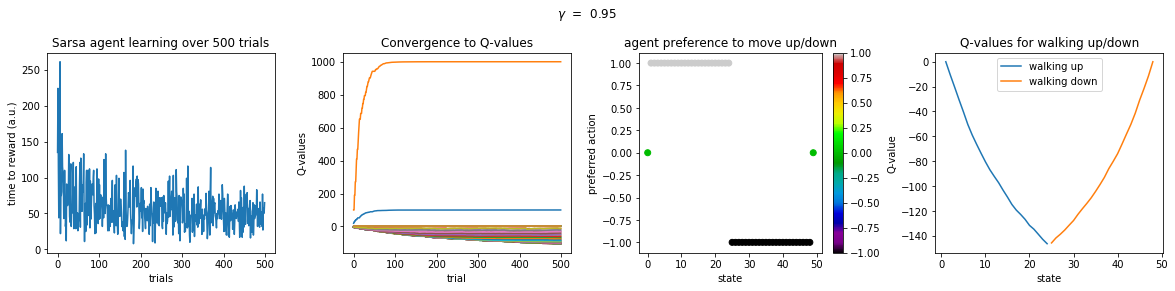

continuing with trial 10000...
continuing with trial 20000...
continuing with trial 30000...
continuing with trial 40000...


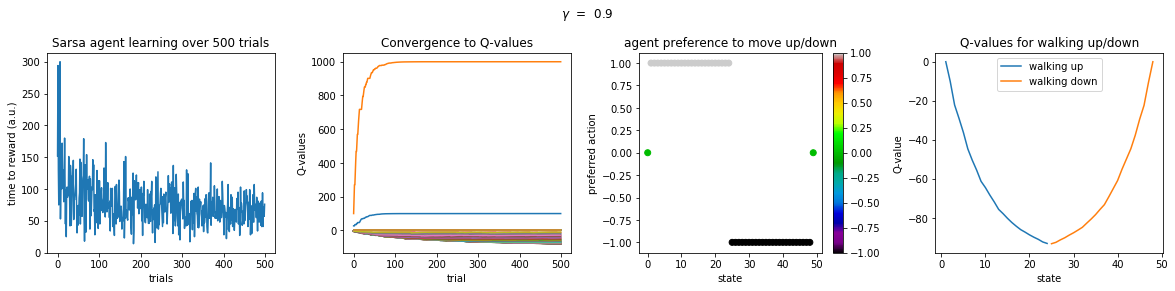

continuing with trial 10000...
continuing with trial 20000...
continuing with trial 30000...
continuing with trial 40000...


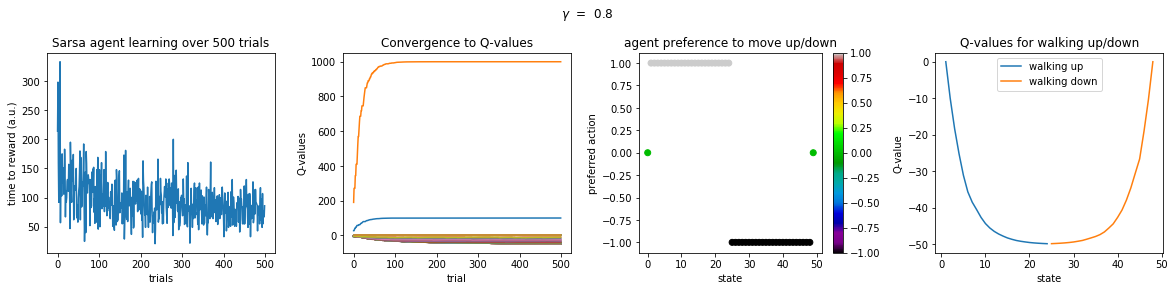

In [7]:
# 1.3

gammas = [.99,.95,.9,.8]

for i, gamma in enumerate(gammas):
  Q3, ttc3 = run_SARSA_agent(Q,rewards,trials,eta,gamma,eps,ttc)
  plot_Q(Q3, ttc3, gamma)

As gamma decreases, the Q-values for states of negative reward become less extreme and, moving towards reward states, they change in a more exponential manner. Convergence to the Q-values of the reward states appears to be the same, as do the preference for up vs. down in any given state. However, the time it takes the agent to reach the reward increases. This can be explained by the agent more highly discounting states that lead to less immediate rewards, so there is more exploration at the beginning of learning.

**2 Gridworld**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import base64
from tempfile import NamedTemporaryFile
from IPython.display import HTML

fps_default = 5.
def display_animation(anim, fps=fps_default, writer='avconv'):
    plt.close(anim._fig)

    # needs avconv installed
    #return HTML(anim_to_html(anim, fps, writer))

    # possibly needs ffmpeg (?)
    #return HTML(anim.to_html5_video())

    return HTML(anim.to_jshtml())

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim, fps, writer):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            # Python 3 may require explicit construction of writer object:
            # writer = animation.AVConvWriter(fps=fps, extra_args=['-vcodec', 'libx264'])
            anim.save(f.name, fps=fps, writer=writer, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video)

    return VIDEO_TAG.format(anim._encoded_video.decode('ascii'))

class Gridworld:
    """
    A class that implements a quadratic NxN gridworld.

    Methods:

    run(N_trials=10,N_runs=1)  : Run 'N_trials' trials. A trial is finished,
                                    when the agent reaches the reward location.
    visualize_trial()          : Run a single trial with graphical output.
    reset()                    : Make the agent forget everything he has learned.
    plot_Q()                   : Plot of the Q-values .
    learning_curve()           : Plot the time it takes the agent to reach the target
                                    as a function of trial number.
    navigation_map()           : Plot the movement direction with the highest
                                    Q-value for all positions.
    """

    def __init__(self, N, reward_position=(0,0), epsilon=.5,
                 obstacle=True, lambda_eligibility=0.):
        """
        Creates a quadratic NxN gridworld.

        Mandatory argument:
        N: size of the gridworld

        Optional arguments:
        reward_position = (x_coordinate,y_coordinate): the reward location
        obstacle = True:  Add a wall to the gridworld.
        """

        # gridworld size
        self.N = N

        # reward location
        self.reward_position = reward_position

        # reward administered t the target location and when
        # bumping into walls
        self.reward_at_target = 1.
        self.reward_at_wall   = -0.5

        # probability at which the agent chooses a random
        # action. This makes sure the agent explores the grid.
        self.epsilon = epsilon

        # learning rate
        self.eta = 0.1

        # discount factor - quantifies how far into the future
        # a reward is still considered important for the
        # current action
        self.gamma = 0.99

        # the decay factor for the eligibility trace the
        # default is 0., which corresponds to no eligibility
        # trace at all.
        self.lambda_eligibility = lambda_eligibility

        # is there an obstacle in the room?
        self.obstacle = obstacle

        # draw animation of agent exploring?
        self._visualize = False

        # initialize the Q-values etc.
        self._init_run()

    def run(self,N_trials=10,N_runs=1):
        self.latencies = np.zeros(N_trials)

        for _ in range(N_runs):
            self._init_run()
            latencies = self._learn_run(N_trials=N_trials)
            self.latencies += latencies/N_runs

    def visualize_trial(self):
        """
        Run a single trial with a graphical display that shows in
                red   - the position of the agent
                blue  - walls/obstacles
                green - the reward position

        Note that for the simulation, exploration is reduced -> self.epsilon=0.1

        """
        # store the old exploration/exploitation parameter
        epsilon = self.epsilon

        # favor exploitation, i.e. use the action with the
        # highest Q-value most of the time
        self.epsilon = 0.1

        self._init_visualization()
        self._run_trial()

        # restore the old exploration/exploitation factor
        self.epsilon = epsilon

        return self._finish_visualization()

    def learning_curve(self,log=False,filter_t=1.):
        """
        Show a running average of the time it takes the agent to reach the target location.

        Options:
        filter_t=1. : timescale of the running average.
        log    : Logarithmic y axis.
        """
        plt.figure()
        plt.xlabel('trials')
        plt.ylabel('time to reach target')
        latencies = np.array(self.latency_list)
        # calculate a running average over the latencies with a averaging time 'filter_t'
        for i in range(1,latencies.shape[0]):
            latencies[i] = latencies[i-1] + (latencies[i] - latencies[i-1])/float(filter_t)

        if not log:
            plt.plot(self.latencies)
        else:
            plt.semilogy(self.latencies)

    def navigation_map(self):
        """
        Plot the direction with the highest Q-value for every position.
        Useful only for small gridworlds, otherwise the plot becomes messy.
        """
        self.x_direction = np.zeros((self.N,self.N))
        self.y_direction = np.zeros((self.N,self.N))

        self.actions = np.argmax(self.Q[:,:,:],axis=2)
        self.y_direction[self.actions==0] = 1.
        self.y_direction[self.actions==1] = -1.
        self.y_direction[self.actions==2] = 0.
        self.y_direction[self.actions==3] = 0.

        self.x_direction[self.actions==0] = 0.
        self.x_direction[self.actions==1] = 0.
        self.x_direction[self.actions==2] = 1.
        self.x_direction[self.actions==3] = -1.

        plt.figure(figsize=(self.N, self.N))
        plt.quiver(self.x_direction,self.y_direction, pivot="mid")
        plt.axis([-0.5, self.N - 0.5, -0.5, self.N - 0.5])

    def reset(self):
        """
        Reset the Q-values (and the latency_list).

        Instant amnesia -  the agent forgets everything he has learned before
        """
        self.Q = np.random.rand(self.N,self.N,4)
        self.latency_list = []

    def plot_Q(self):
        """
        Plot the dependence of the Q-values on position.
        The figure consists of 4 subgraphs, each of which shows the Q-values
        colorcoded for one of the actions.
        """
        plt.figure(figsize=(0.75*self.N, 0.75*self.N))
        for i in range(4):
            plt.subplot(2,2,i+1)
            plt.imshow(self.Q[:,:,i],interpolation='nearest',origin='lower',vmax=1.1)
            if i==0:
                plt.title('Up')
            elif i==1:
                plt.title('Down')
            elif i==2:
                plt.title('Right')
            else:
                plt.title('Left')

            plt.colorbar()

    def _init_run(self):
        """
        Initialize the Q-values, eligibility trace, position etc.
        """
        # initialize the Q-values and the eligibility trace
        self.Q = 0.01 * np.random.rand(self.N,self.N,4) + 0.1
        self.e = np.zeros((self.N,self.N,4))

        # list that contains the times it took the agent to reach the target for all trials
        # serves to track the progress of learning
        self.latency_list = []

        # initialize the state and action variables
        self.x_position = None
        self.y_position = None
        self.action = None

    def _learn_run(self,N_trials=10):
        """
        Run a learning period consisting of N_trials trials.

        Options:
        N_trials :     Number of trials

        Note: The Q-values are not reset. Therefore, running this routine
        several times will continue the learning process. If you want to run
        a completely new simulation, call reset() before running it.

        """
        for _ in range(N_trials):
            # run a trial and store the time it takes to the target
            latency = self._run_trial()
            self.latency_list.append(latency)

        return np.array(self.latency_list)

    def _run_trial(self):
        """
        Run a single trial on the gridworld until the agent reaches the reward position.
        Return the time it takes to get there.
        """
        # Initialize the latency (time to reach the target) for this trial
        latency = 0.

        # Choose a random initial position and make sure that it is not in the wall.
        # Needed here:
        # self.x_position, self.y_position, self._is_wall


        # Run the trial by choosing an action and repeatedly applying SARSA
        # until the reward has been reached.
        # Needed here:
        # self._choose_action, self._arrived,  self._update_state, self._update_Q


        return latency

    def _update_Q(self):
        """
        Update the current estimate of the Q-values according to SARSA.
        """
        # Update the eligibility trace

        # Update the Q-values
        # deltaQ = eta * e * [r - (Q_old - gamma * Q)]
        # Needed here:
        # self.action, self.x_position, self.y_position, self._reward
        # plus _old versions of above and more.

        # Finally we visualize the state if requested by calling code.
        self._visualize_current_state()

    def _choose_action(self):
        """
        Choose the next action based on the current estimate of the Q-values.
        The parameter epsilon determines, how often agent chooses the action
        with the highest Q-value (probability 1-epsilon). In the rest of the cases
        a random action is chosen.
        """
        # Be sure to store the old action before choosing a new one.
        # Needed here:
        # self.action, self.action_old, self.epsilon, self.Q, self.x_position, self.y_position
        pass

    def _arrived(self):
        """
        Check if the agent has arrived.
        """
        return (self.x_position == self.reward_position[0] and self.y_position == self.reward_position[1])

    def _reward(self):
        """
        Evaluates how much reward should be administered when performing the
        chosen action at the current location
        """
        if self._arrived():
            return self.reward_at_target

        if self._wall_touch:
            return self.reward_at_wall
        else:
            return 0.

    def _update_state(self):
        """
        Update the state according to the old state and the current action.
        """
        # remember the old position of the agent
        self.x_position_old = self.x_position
        self.y_position_old = self.y_position

        # update the agents position according to the action
        # move to the down?
        if self.action == 0:
            self.x_position += 1
        # move to the up
        elif self.action == 1:
            self.x_position -= 1
        # move right?
        elif self.action == 2:
            self.y_position += 1
        # move left?
        elif self.action == 3:
            self.y_position -= 1
        else:
            print("There must be a bug. This is not a valid action!")

        # check if the agent has bumped into a wall.
        self._wall_touch = self._is_wall()
        if self._wall_touch:
            self.x_position = self.x_position_old
            self.y_position = self.y_position_old

    def _is_wall(self,x_position=None,y_position=None):
        """
        This function returns, if the given position is within an obstacle
        If you want to put the obstacle somewhere else, this is what you have
        to modify. The default is a wall that starts in the middle of the room
        and ends at the right wall.

        If no position is given, the current position of the agent is evaluated.
        """
        if x_position == None or y_position == None:
            x_position = self.x_position
            y_position = self.y_position

        # check if the agent is trying to leave the gridworld
        if x_position < 0 or x_position >= self.N or y_position < 0 or y_position >= self.N:
            return True

        # check if the agent has bumped into an obstacle in the room
        if self.obstacle:
            if y_position == int(self.N/2) and x_position>self.N/2:
                return True

        # if none of the above is the case, this position is not a wall
        return False

    def _visualize_current_state(self):
        """
        Show the gridworld. The squares are colored in
        red - the position of the agent - turns yellow when reaching the target or running into a wall
        blue - walls
        green - reward
        """
        if self._visualize:
            self._display = np.copy(self._display)
            # set the agents color
            self._display[self.x_position_old,self.y_position_old,:] = 0
            self._display[self.x_position,self.y_position,0] = 1
            if self._wall_touch:
                self._display[self.x_position,self.y_position,:] = 1

            # update the figure
            self._append_image(self._display)

    def _init_visualization(self):
        import __main__ as main
        self._notebook = not hasattr(main, '__file__')

        self._visualize = True
        # create the figure
        self._anifig = plt.figure()
        self._aniax = self._anifig.add_subplot(1,1,1)
        # initialize the content of the figure (RGB at each position)
        self._anim = []
        self._display = np.zeros((self.N,self.N,3))

        # position of the agent
        self._display[self.x_position,self.y_position,0] = 1
        # set the reward locations
        self._display[self.reward_position[0],self.reward_position[1],[0,1]] = 1

        for x in range(self.N):
            for y in range(self.N):
                if self._is_wall(x_position=x,y_position=y):
                    self._display[x,y,2] = 1.

        self._append_image(self._display)

    def _append_image(self, display):
        display = (self._aniax.imshow(display,interpolation='nearest',origin='lower'),)
        self._anim.append(display)

    def _finish_visualization(self):
        self._visualize = False
        if self._notebook:
            anim = animation.ArtistAnimation(self._anifig, self._anim, blit=True)
            return anim
        else:
            _ani = animation.ArtistAnimation(
                self._anifig, self._anim, interval=1000./fps_default, blit=True,
                repeat_delay=1000)
            plt.show()


In [0]:
def my_run_trial(self):
    """
    Run a single trial on the gridworld until the agent reaches the reward position.
    Return the time it takes to get there.
    """
    # Initialize the latency (time to reach the target) for this trial
    latency = 0.

    # Choose a random initial position and make sure that it is not in the wall.
    self.x_position = np.random.randint(self.N)
    self.y_position = np.random.randint(self.N)
    
    while self._is_wall(self.x_position, self.y_position):
      self.x_position = np.random.randint(self.N)
      self.y_position = np.random.randint(self.N)

    # Run the trial by choosing an action and repeatedly applying SARSA
    # until the reward has been reached.

    while not self._arrived():
      # TODO: finish proper implementation of self._choose_action(), self._update_Q(latency)
      self._choose_action()
      self._update_Q(latency)
      self._update_state()
      latency += 1 # update latency

    return latency

def _update_Q(self,latency):
    """
    Update the current estimate of the Q-values according to SARSA. (Single-Q implementation)
    """
    # TODO: update eligibility trace and Q-values for all states visiting, not just 1
    # for all old x_ and y_positions, and all old actions, go through each previous state visited
    # calculate eligibility trace
    # calculate deltaQ
    # update Qs

    # Needed here:
    # self.action, self.x_position, self.y_position, self._reward
    # plus _old versions of above and more.

    # Update single eligibility trace 
    self.e = (self.lambda_eligibility * self.gamma) ** (latency) # latency - how long ago state was visited

    # Update the Q-values
    deltaQ = self.eta * self.e * [self._reward() - (self.Q_old - self.gamma * self.Q)]

    # Update single  Q-value 
    self.Q_old = self.Q # storing old Q value
    self.Q += deltaQ


    # Finally we visualize the state if requested by calling code.
    self._visualize_current_state()

def _choose_action(self):
    """
    Choose the next action based on the current estimate of the Q-values.
    The parameter epsilon determines, how often agent chooses the action
    with the highest Q-value (probability 1-epsilon). In the rest of the cases
    a random action is chosen.
    """
    # Be sure to store the old action before choosing a new one.
    # Needed here:
    # self.action, self.action_old, self.epsilon, self.Q, self.x_position, self.y_position

    self.action_old = self.action
    
    # TODO: determine 4 states in vicinity of self.x_position, self.y_position and find argmax
    # TODO: implement epsilon-greedy policy to determine self.action
    
    pass


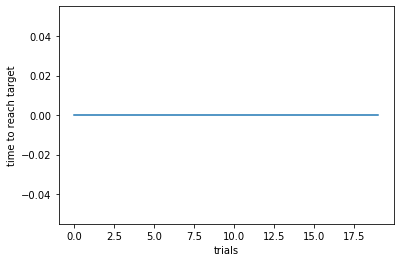

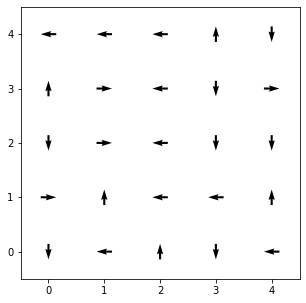

In [10]:

g1 = Gridworld(5)
g1.run(N_trials=20)
g1.learning_curve()
g1.navigation_map()